In [1]:
# Data Preparation and Image Division
!pip install torch_snippets
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torchvision.transforms as T
import torchvision

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch_snippets import *

In [3]:
data_folder = '/root/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Resize the image to fit into the imagenet architecture
img_resize = T.Compose([
    T.ToTensor(),
    T.Resize((224,224)),
])

cifar100 = torchvision.datasets.CIFAR100(data_folder,train=True,transform=img_resize,download=True)
trn_images = cifar100.data
trn_dl = DataLoader(cifar100,batch_size=64,shuffle=True,drop_last=True)

val_cifar100 = torchvision.datasets.CIFAR100(data_folder,train=False,transform=img_resize,download=True)
val_dl = DataLoader(val_cifar100,batch_size=64,shuffle=False,drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


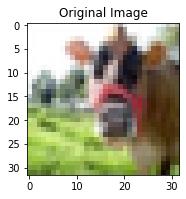

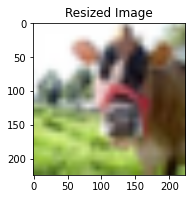

The original image size is : (32, 32, 3)

The resized image size is : torch.Size([3, 224, 224])

In [4]:
# Perform the dimension rearrangement
import matplotlib.pyplot as plt
img = trn_images[0]
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.show()

new_img = img_resize(img)
plt.subplot(1,2,2)
plt.imshow(new_img.permute(1,2,0))
plt.title("Resized Image")
plt.show()
print(f"The original image size is : {img.shape}")
print(f"The resized image size is : {new_img.shape}")

In [5]:
# In the paper, it states that they divided each image into 16x16 image patches.
# The following code does the job
# First of all, add a batch dim to the resized image.
new_img2 = new_img.unsqueeze(0)
new_img.shape
img_patches = rearrange(new_img2,'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',p1=16,p2=16)
print(f'Resized image diemnsion is {new_img.shape}')
print(f'Flattened patch dimension is {img_patches.shape}')

Resized image diemnsion is torch.Size([3, 224, 224])

Flattened patch dimension is torch.Size([1, 196, 768])

In [6]:
class ImgPatch_Embedding(nn.Module):
  def __init__(self,in_channel=int(3),patch_size=int(16),emb_size=int(3*16*16),img_size=int(224)):
    super().__init__()
    self.patch_size = patch_size
    self.flatten = nn.Sequential(
        nn.Conv2d(in_channel,emb_size,kernel_size=patch_size,stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )
    self.BERT_token = nn.Parameter(torch.randn(1,1,emb_size))
    self.POS_embedding = nn.Parameter(torch.randn((img_size//patch_size)**2+1,emb_size))
  def forward(self,x:torch.Tensor):
    b, _, _, _ = x.shape
    x = self.flatten(x)
    BERT_tokens = repeat(self.BERT_token,'() n e -> b n e',b=b)
    x = torch.cat([BERT_tokens,x],dim=1)
    x += self.POS_embedding
    return torch.Tensor(x)

ImgPatch_Embedding()(new_img2).shape

torch.Size([1, 197, 768])

In [7]:
class res_add(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [9]:
class MLP(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [10]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            res_add(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            res_add(nn.Sequential(
                nn.LayerNorm(emb_size),
                MLP(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [11]:
patches_embedded = ImgPatch_Embedding()(new_img2)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [12]:
class TransformerEncoder(nn.Sequential):
  def __init__(self,depth = int(12),**kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


In [13]:
class Classification(nn.Sequential):
  def __init__(self,emb_size=int(768),n_classes=int(100)):
    super().__init__(
        Reduce('b n e-> b e',reduction='mean'),
        nn.LayerNorm(emb_size),
        nn.Linear(emb_size,n_classes)
    )

class ViT(nn.Sequential):
  def __init__(self,in_channels=int(3),patch_size=int(16),
               emb_size=int(768),img_size=int(224),
               depth=int(12),n_classes=int(100),
               **kwargs):
    super().__init__(
        ImgPatch_Embedding(in_channels,patch_size,emb_size,img_size),
        TransformerEncoder(depth,emb_size=emb_size,**kwargs),
        Classification(emb_size,n_classes)
    )

In [14]:
model = ViT().to(device)

loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 30

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       patience=0,factor=0.5,
                                                       threshold=0.001,
                                                       verbose=True,
                                                       min_lr=1e-5,
                                                       threshold_mode='abs')

def get_loss(preds,targets):
  loss = loss_func(preds,targets)
  acc = (torch.max(preds,1)[1]==targets).float().mean()
  return loss, acc

criterion = get_loss

def train_batch(data,model,optimizer,loss_fn):
  model.train()
  optimizer.zero_grad()
  ims, targets = data
  _targets = model(ims.to(device))
  loss, acc = criterion(_targets,targets.to(device))
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(data,model,criterion):
  model.eval()
  ims,targets = data
  _targets = model(ims.to(device))
  loss, acc = criterion(_targets,targets.to(device))
  return loss.item(), acc.item()

In [15]:
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, data in enumerate(iter(trn_dl)):
    loss, acc = train_batch(data,model,optimizer,criterion)
    log.record(epoch+(ix+1)/N,trn_loss=loss,trn_acc=acc,end='\r')

  N = len(val_dl)
  for ix, data in enumerate(iter(val_dl)):
    loss, acc = validate_batch(data,model,criterion)
    scheduler.step(loss)
    log.record(epoch+(ix+1)/N,val_loss=loss,val_acc=acc,end='\r')
  
  log.report_avgs(epoch+1)

EPOCH: 0.019  val_loss: 249.967  val_acc: 0.125  (386.63s - 602756.22s remaining)Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
EPOCH: 0.026  val_loss: 254.603  val_acc: 0.109  (386.82s - 452188.93s remaining)Epoch 00005: reducing learning rate of group 0 to 2.5000e-04.
EPOCH: 0.032  val_loss: 254.672  val_acc: 0.062  (387.00s - 361845.74s remaining)Epoch 00006: reducing learning rate of group 0 to 1.2500e-04.
EPOCH: 0.038  val_loss: 257.606  val_acc: 0.031  (387.19s - 301620.38s remaining)Epoch 00007: reducing learning rate of group 0 to 6.2500e-05.
EPOCH: 0.045  val_loss: 259.669  val_acc: 0.000  (387.37s - 258599.78s remaining)Epoch 00008: reducing learning rate of group 0 to 3.1250e-05.
EPOCH: 0.051  val_loss: 262.385  val_acc: 0.047  (387.56s - 226334.79s remaining)Epoch 00009: reducing learning rate of group 0 to 1.5625e-05.
EPOCH: 0.058  val_loss: 250.796  val_acc: 0.016  (387.74s - 201238.93s remaining)Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.

100%|██████████| 131/131 [00:00<00:00, 184.47it/s]


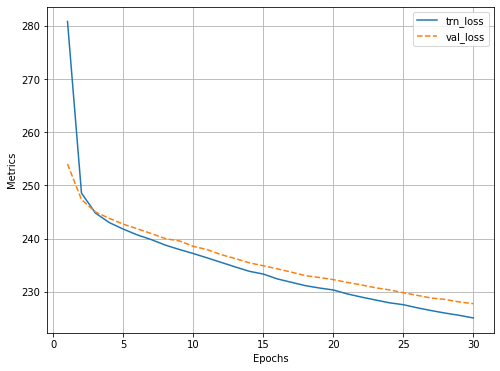

In [16]:
log.plot_epochs(['trn_loss','val_loss'])

100%|██████████| 131/131 [00:00<00:00, 187.24it/s]


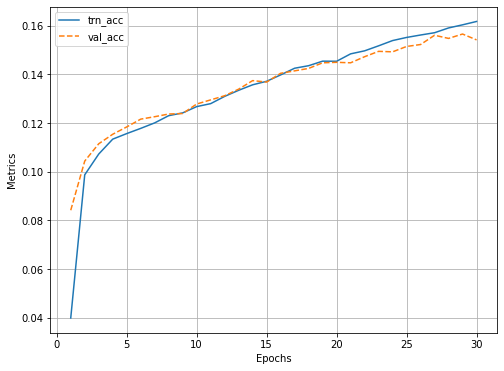

In [17]:
log.plot_epochs(['trn_acc','val_acc'])

'